# Data Clean Up

This notebook is a part of the project title: Predicting US monthly electricity consumption(sold) by State. 

After gathering data from different sources. The data are put together in "Year", "Month", "State" and "data" columns format. Export as CSV  in order to be merged together in a single columns. 

## Data Sources: 

1. Monthly energy consumption, revenue, prices, and number of customer by sector by state since 1990 from https://www.eia.gov/electricity/data.php#sales and https://www.eia.gov/electricity/sales_revenue_price/ 
2. Annual and quarter GSP  by state  from and https://fred.stlouisfed.org for example, https://fred.stlouisfed.org/series/ALNGSP, https://fred.stlouisfed.org/series/ALNQGSP
3. Population by state from https://fred.stlouisfed.org, example, https://fred.stlouisfed.org/series/ALPOP
4. Total personal income by state https://fred.stlouisfed.org, example, https://fred.stlouisfed.org/series/ALOTOT
5. Unemployment rate by state https://fred.stlouisfed.org. example , https://fred.stlouisfed.org/series/CAUR
6. Monthly consumer price index by state excluding food and electricity from https://fred.stlouisfed.org/series/CPILFENS
7. Number of heating and cooling days by state from   https://www.ncdc.noaa.gov/ushcn/data-access
8. Shorterm energy outlook https://www.eia.gov/outlooks/steo/data/browser/


## Table of Content

- [Electricity Data](#edata) 
- [Population Data](#pop)
- [Heating and Cooling days by State](#heatcool)
- [Unempolyment by State](#ur)
- [Personal Income by State](#income)
- [Consumer Price Index US](#cpi)
- [GDP per State (GSP)](#gsp) 
- [hort Term Energy Outlook<](#steo)
- [Regional](#group)
- [State Size](#size)
- [Combine All Data](#combine)
- [Explore missing data](#missing)


# Boiler Plate Section

In [1]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'

In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia':'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [4]:
import simplejson as json
with open(mfolder+'us_state_map.geojson','r') as fp:
    statedata = json.load(fp)

In [5]:
blues = ['#FFF7FB', '#ECE7F2', '#D0D1E6', '#A6BDDB', '#74A9CF',
         '#3690C0', '#0570B0', '#045A8D', '#023858']
_color_idx = 0

def draw_polygon(subplot, coords, **kwargs):
    xs, ys = zip(*coords)
    kwargs['alpha']=0.5
    subplot.fill(xs, ys, **kwargs)

In [6]:
from collections import defaultdict

state2poly = defaultdict(list)
for f in statedata['features']:
    state = f['properties']['STUSPS']
    geo = f['geometry']
    for coords in geo['coordinates']:
        state2poly[state].append(coords)


In [7]:
def draw_state(subplot, name, **kwargs):
    """
    draw_state(subplot, state, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.  *state* is state abbreviation
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    kwargs['color'] = "#FFFFFF"
    for polygon in state2poly[name]:
        draw_polygon(subplot, polygon, **kwargs)

# Clean up Electricity data<a id='edata'></a> 

Obtained report sales, revenue, number of account and prices from three sections of EIA website. The file sale_revenue_by_state.csv contains sales, revenues, prices and number of accounts all the way back to 1990, but lack recent data in 2019. This data is merged with another sets are from the EIA's interactive web. 

For sales, revenue, prices and number of customer accounts I did the following procedures

- Inspect of two sets of data and check for consistency
- Convert unit
- Change the table structure with 'Year', 'Month', 'State' columns and each sectors as it own columns. However, the Transportation sector has only be recored recently, so I combined them with other columns.
- Merge data from two or more sets. 
- Export files as .csv

## sale_revenue_by_state.csv

In [204]:
sale_rev = pd.read_csv('E:/Users/Fern/energy_data/energy/sale_revenue_by_state.csv',header=[0,1])
sale_rev.head()

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,RESIDENTIAL,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,COMMERCIAL,Unnamed: 9_level_0,...,Unnamed: 18_level_0,Unnamed: 19_level_0,OTHER,Unnamed: 21_level_0,Unnamed: 22_level_0,Unnamed: 23_level_0,TOTAL,Unnamed: 25_level_0,Unnamed: 26_level_0,Unnamed: 27_level_0
,Year,Month,State,Status,Revenue(1k$),Sales(MWh),Customers_count,Price(c_per_kWh),Revenue(1k$),Sales(MWh),...,Customers_count,Price(c_per_kWh),Revenue(1k$),Sales(MWh),Customers_count,Price(c_per_kWh),Revenue(1k$),Sales(MWh),Customers_count,Price(c_per_kWh)
0,1990,1,AK,Final,17477,181752,0,9.62,15818,178259,...,0,0.0,1918,14816,0,12.95,38848,416438,0,9.33
1,1990,1,AL,Final,123332,2070093,0,5.96,54495,820415,...,0,0.0,2851,53954,0,5.28,268440,5044008,0,5.32
2,1990,1,AR,Final,72506,1026320,0,7.06,30966,474988,...,0,0.0,3117,47600,0,6.55,143635,2331399,0,6.16
3,1990,1,AZ,Final,109332,1396499,0,7.83,82694,1081793,...,0,0.0,7833,151064,0,5.19,243133,3439153,0,7.07
4,1990,1,CA,Final,597161,6168009,0,9.68,508517,6011774,...,0,0.0,32100,869565,0,3.69,1406536,17504013,0,8.04


In [205]:
sale_rev.tail()

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,RESIDENTIAL,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,COMMERCIAL,Unnamed: 9_level_0,...,Unnamed: 18_level_0,Unnamed: 19_level_0,OTHER,Unnamed: 21_level_0,Unnamed: 22_level_0,Unnamed: 23_level_0,TOTAL,Unnamed: 25_level_0,Unnamed: 26_level_0,Unnamed: 27_level_0
,Year,Month,State,Status,Revenue(1k$),Sales(MWh),Customers_count,Price(c_per_kWh),Revenue(1k$),Sales(MWh),...,Customers_count,Price(c_per_kWh),Revenue(1k$),Sales(MWh),Customers_count,Price(c_per_kWh),Revenue(1k$),Sales(MWh),Customers_count,Price(c_per_kWh)
17794,2019,1,VT,Preliminary,36985,221058,315437,16.73,27029,173745,...,0,0.00,0,0,0,0.0,77567,521061,372650,14.89
17795,2019,1,WA,Preliminary,379753,4079098,3112054,9.31,229187,2643971,...,6,10.04,0,0,0,0.0,710159,8891622,3538970,7.99
17796,2019,1,WI,Preliminary,309640,2211456,2745830,14.00,215160,2014906,...,2,13.48,0,0,0,0.0,671988,6190346,3111199,10.86
17797,2019,1,WV,Preliminary,128466,1321849,860777,9.72,59296,707239,...,0,0.00,0,0,0,0.0,259764,3270054,1017136,7.94
17798,2019,1,WY,Preliminary,34776,329320,275961,10.56,30874,339003,...,0,0.00,0,0,0,0.0,122490,1550021,344681,7.90


In [206]:
# change column names
cols = sale_rev.columns

newcol = []
for i, col in enumerate(cols):
    if (i % 4) == 0:
        title = col[0]
    
    if i < 3:
        newcol.append(col[1])
    else:
        newcol.append(title[:3]+'_'+col[1])
        
#over write columns name using new column names        
sale_rev.columns = newcol

In [207]:
# check data
sale_rev.tail()

,Year,Month,State,Unn_Status,RES_Revenue(1k$),RES_Sales(MWh),RES_Customers_count,RES_Price(c_per_kWh),COM_Revenue(1k$),COM_Sales(MWh),...,TRA_Customers_count,TRA_Price(c_per_kWh),OTH_Revenue(1k$),OTH_Sales(MWh),OTH_Customers_count,OTH_Price(c_per_kWh),TOT_Revenue(1k$),TOT_Sales(MWh),TOT_Customers_count,TOT_Price(c_per_kWh)
17794,2019,1,VT,Preliminary,36985,221058,315437,16.73,27029,173745,...,0,0.00,0,0,0,0.0,77567,521061,372650,14.89
17795,2019,1,WA,Preliminary,379753,4079098,3112054,9.31,229187,2643971,...,6,10.04,0,0,0,0.0,710159,8891622,3538970,7.99
17796,2019,1,WI,Preliminary,309640,2211456,2745830,14.00,215160,2014906,...,2,13.48,0,0,0,0.0,671988,6190346,3111199,10.86
17797,2019,1,WV,Preliminary,128466,1321849,860777,9.72,59296,707239,...,0,0.00,0,0,0,0.0,259764,3270054,1017136,7.94
17798,2019,1,WY,Preliminary,34776,329320,275961,10.56,30874,339003,...,0,0.00,0,0,0,0.0,122490,1550021,344681,7.90


In [208]:
sale_rev.describe()

,Year,Month,RES_Revenue(1k$),RES_Sales(MWh),RES_Customers_count,RES_Price(c_per_kWh),COM_Revenue(1k$),COM_Sales(MWh),COM_Customers_count,COM_Price(c_per_kWh),...,TRA_Customers_count,TRA_Price(c_per_kWh),OTH_Revenue(1k$),OTH_Sales(MWh),OTH_Customers_count,OTH_Price(c_per_kWh),TOT_Revenue(1k$),TOT_Sales(MWh),TOT_Customers_count,TOT_Price(c_per_kWh)
count,17799.000000,17799.000000,1.779900e+04,1.779900e+04,1.779900e+04,17799.000000,1.779900e+04,1.779900e+04,1.779900e+04,17799.000000,...,17799.000000,17799.000000,17799.000000,1.779900e+04,17799.0,17799.000000,1.779900e+04,1.779900e+04,1.779900e+04,17799.000000
mean,2004.042980,6.484241,2.075218e+05,2.034171e+06,1.029424e+06,10.178624,1.687193e+05,1.854756e+06,1.432707e+05,8.717945,...,2.219563,2.698180,4948.239508,7.343562e+04,0.0,3.642525,4.747362e+05,5.600202e+06,1.179033e+06,8.493965
std,8.393226,3.459714,2.500146e+05,2.156849e+06,2.056480e+06,3.788402,2.248017e+05,2.008221e+06,2.798574e+05,3.279133,...,23.079422,4.562531,13116.323140,1.872142e+05,0.0,4.786899,5.495824e+05,5.437331e+06,2.347576e+06,3.442677
min,1990.000000,1.000000,4.708000e+03,7.388100e+04,0.000000e+00,4.180000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,2.538900e+04,3.020170e+05,0.000000e+00,3.060000
25%,1997.000000,3.000000,4.757450e+04,4.663850e+05,0.000000e+00,7.520000,3.944450e+04,4.801630e+05,0.000000e+00,6.510000,...,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,1.168845e+05,1.534200e+06,0.000000e+00,6.140000
50%,2004.000000,6.000000,1.268890e+05,1.476609e+06,0.000000e+00,9.420000,9.017700e+04,1.223551e+06,0.000000e+00,8.070000,...,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,2.977780e+05,4.203282e+06,0.000000e+00,7.780000
75%,2011.000000,9.000000,2.618990e+05,2.739044e+06,1.287832e+06,11.850000,2.052800e+05,2.374109e+06,1.921810e+05,9.970000,...,0.000000,6.685000,4269.500000,5.740550e+04,0.0,6.690000,6.020725e+05,7.630984e+06,1.525284e+06,9.885000
max,2019.000000,12.000000,2.443657e+06,1.862066e+07,1.397101e+07,40.160000,2.308117e+06,1.446088e+07,1.897985e+06,37.210000,...,520.000000,116.670000,120161.000000,1.639053e+06,0.0,48.800000,5.541783e+06,4.252625e+07,1.587646e+07,36.370000


Define clean up functions

In [22]:
def get_state_sector(df,to_drop=3):
    ''' extract state and sector from the data
        drop the row corresponded to total US data 
    '''
    # extract source_key
    df['state_sector'] = df['source key'].str.split('.',n=4, expand=True)[2]
    # extract state and sector 
    df['Sector'] = df['state_sector'].str.split('-',n=2, expand=True)[1]
    df['State'] = df['state_sector'].str.split('-',n=2, expand=True)[0]

    df = df.drop(df.columns[:to_drop],axis=1).dropna()
    
    # keep only the state 
    df = df[df['State'].str.len()==2]
    df = df[df['State'] != 'US']
    return df.drop('state_sector',axis=1) 

In [23]:
def pivot_data(df,name='value'):
    '''  pivot df into 'Year','Month', 'State', and 'Data' columns
    '''
    temp = df.melt(id_vars=['State','Sector'])
    temp.columns = ['State','Sector','date',name]
    temp.value = temp.value.str.replace('--','0')
       
    temp_pivot = pd.pivot_table(temp,index=['date','State'],values=name,columns=['Sector'],aggfunc='last').reset_index()
    #print(temp_pivot.head())
    temp_pivot['Year'] = temp_pivot['date'].str.split(' ',n=2,expand=True)[1].astype(int)
    temp_pivot['Month'] = temp_pivot['date'].str.split(' ',n=2,expand=True)[0]
    temp_pivot['Month'] =  pd.to_datetime(temp_pivot['Month'], format='%b').dt.month
    temp_pivot.drop('date',axis=1,inplace=True)
    temp_pivot.sort_values(['Year','Month','State'],inplace=True)
    return temp_pivot

In [24]:
def concat_replace(old,new):
    ''' concat two energy data 
    combine transportation and other column
    drop old transportation data
    '''
    new['OTH'] = new['OTH'].str.replace('--','0')
    new['TRA'] = new['TRA'].str.replace('--','0')
    
    temp = new[(new['Year']==2019)&(new['Month']==2)]
    
    # concat two df
    temp = pd.concat([old,temp],sort=False)
    temp.sort_values(['Year','Month','State'],inplace=True)
    # add transportation columns into others 
    temp['OTH'] = temp['OTH'] + temp['TRA']
    # drop transportation column
    return temp.drop('TRA',axis=1)

## Clean up revenue data

Data in 2019 Jan and Feb are not update, more with another files.

In [37]:
# list all columns with rev data
revcols = list(sale_rev.columns[sale_rev.columns.str.contains('Rev')])
revcols = ['Year','Month','State'] + revcols

In [38]:
# put the data in a separate df 
revold = sale_rev[revcols].copy()
revold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
revold.sort_values(['Year','Month','State'],inplace=True)

In [39]:
# load revenu data from another file
rev = pd.read_csv('E:/Users/Fern/energy_data/energy/Revenue_from_retail_sales_of_electricity.csv',skiprows=5).drop(0)
rev.head()

,Revenue from retail sales of electricity,million dollars,source key,Jan 2001,Feb 2001,Mar 2001,Apr 2001,May 2001,Jun 2001,Jul 2001,...,May 2018,Jun 2018,Jul 2018,Aug 2018,Sep 2018,Oct 2018,Nov 2018,Dec 2018,Jan 2019,Feb 2019
1,United States : all sectors,million dollars,ELEC.REV.US-ALL.M,20978,18700,18880,17856,18970,21977,24876,...,31029,35963,40773,41631,35519,31830,29789,31538,33266,30474
2,United States : residential,million dollars,ELEC.REV.US-RES.M,9827,8030,7721,6974,7217,9014,10901,...,13600,16889,20094,20306,16710,13720,13384,15285,16580,14768
3,United States : commercial,million dollars,ELEC.REV.US-COM.M,6587,6119,6470,6269,6794,7779,8592,...,11821,13156,14370,14794,12986,12452,11051,11122,11484,10801
4,United States : industrial,million dollars,ELEC.REV.US-IND.M,3952,3945,4061,4006,4303,4458,4631,...,5553,5854,6243,6464,5757,5596,5293,5066,5138,4838
5,United States : transportation,million dollars,ELEC.REV.US-TRA.M,--,--,--,--,--,--,--,...,56,64,65,66,67,63,60,64,65,68


In [41]:
# separate state and sector columns 
rev = get_state_sector(rev)

In [43]:
#pivot the data
rev_pivot = pivot_data(rev)
# check Jan 2019 data
rev_pivot[(rev_pivot['Year']==2019)&(rev_pivot['Month']==1)].head()

Sector,State,ALL,COM,IND,OTH,RES,TRA,Year,Month
4641,AK,112,48,17,0,47,0,2019,1
4642,AL,714,202,155,0,358,0,2019,1
4643,AR,323,79,81,0,162,0,2019,1
4644,AZ,583,215,66,0,302,0,2019,1
4645,CA,3266,1361,392,0,1507,5,2019,1


In [45]:
revold[(revold['Year']==2019 )& (revold['Month']==1) ].head()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
17748,2019,1,AK,46843,48246,16543,0,0,111633
17749,2019,1,AL,357710,201581,154620,0,0,713910
17750,2019,1,AR,162393,79477,80921,4,0,322796
17751,2019,1,AZ,302353,215060,65753,59,0,583225
17752,2019,1,CA,1507350,1361480,391979,5036,0,3265845


The number check out. Both dataset are the same, just in a different unit.

In [46]:
# round number to millions
rev_cols = ['RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']

for rev_col in rev_cols: 
    revold.loc[:,rev_col] = (revold.loc[:,rev_col]/1000).round(2)

revold.head()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
0,1990,1,AK,17.48,15.82,3.64,0.0,1.92,38.85
1,1990,1,AL,123.33,54.50,87.76,0.0,2.85,268.44
2,1990,1,AR,72.51,30.97,37.05,0.0,3.12,143.64
3,1990,1,AZ,109.33,82.69,43.27,0.0,7.83,243.13
4,1990,1,CA,597.16,508.52,268.76,0.0,32.10,1406.54


In [50]:
revall = concat_replace(revold,rev_pivot)

In [52]:
# change columns name 
revall.columns = ['Year', 'Month', 'State', 'Rev_RES', 'Rev_COM',
       'Rev_IND', 'Rev_OTH',
       'Rev_ALL']

In [53]:
revall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17850 entries, 0 to 3722
Data columns (total 8 columns):
Year       17850 non-null int64
Month      17850 non-null int64
State      17850 non-null object
Rev_RES    17850 non-null object
Rev_COM    17850 non-null object
Rev_IND    17850 non-null object
Rev_OTH    17850 non-null object
Rev_ALL    17850 non-null object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


There are monthly data from 1990 to 2019 Feb, and from 51 states, thus 17850 rows.

In [54]:
((2018 - 1990+1)*12 + 2)*51

17850

In [ ]:
# save the data 
revall.to_csv('E:/Users/Fern/energy_data/clean/revenue.csv',index=False)

## Clean up sale data


In [513]:
# list all columns with sale data
salecols = list(sale_rev.columns[sale_rev.columns.str.contains('Sales')])
salecols = ['Year','Month','State'] + salecols

In [514]:
# put the data in a separate df 
saleold = sale_rev[salecols].copy()
saleold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
saleold.sort_values(['Year','Month','State'],inplace=True)

In [515]:
saleold.tail()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
17794,2019,1,VT,221058,173745,126258,0,0,521061
17795,2019,1,WA,4079098,2643971,2167994,558,0,8891622
17796,2019,1,WI,2211456,2014906,1963573,412,0,6190346
17797,2019,1,WV,1321849,707239,1240966,0,0,3270054
17798,2019,1,WY,329320,339003,881697,0,0,1550021


In [516]:
# load sale data from another file
sale = pd.read_csv('E:/Users/Fern/energy_data/energy/Retail_sales_of_electricity.csv',skiprows=4)
sale.head()

,description,units,source key,Jan 2001,Feb 2001,Mar 2001,Apr 2001,May 2001,Jun 2001,Jul 2001,...,May 2018,Jun 2018,Jul 2018,Aug 2018,Sep 2018,Oct 2018,Nov 2018,Dec 2018,Jan 2019,Feb 2019
0,United States : all sectors,million kilowatthours,ELEC.SALES.US-ALL.M,310816,272335,269298,254391,264490,290008,315798,...,298044,333212,369629,377748,331881,304157,285543,307171,323300,292049
1,United States : residential,million kilowatthours,ELEC.SALES.US-RES.M,127066,99878,92805,82454,81731,99407,120707,...,103395,129478,153031,152951,128459,106638,103372,122620,132989,116311
2,United States : commercial,million kilowatthours,ELEC.SALES.US-COM.M,90825,81467,84064,81061,87471,95658,102156,...,112597,121578,130916,134479,121581,115861,104622,107678,111613,102690
3,United States : industrial,million kilowatthours,ELEC.SALES.US-IND.M,83477,82248,83522,82253,86097,85269,83176,...,81461,81527,85041,89632,81192,81023,76927,76213,78033,72371
4,United States : transportation,million kilowatthours,ELEC.SALES.US-TRA.M,--,--,--,--,--,--,--,...,591,628,640,686,648,636,622,660,664,677


In [518]:
# separate state and sector columns 
sale = get_state_sector(sale)

In [521]:
#pivot the data
sale_pivot = pivot_data(sale)
# check the data in Jan 2019
sale_pivot[(sale_pivot['Year']==2019)&(sale_pivot['Month']==1)].head()

Sector,State,ALL,COM,IND,OTH,RES,TRA,Year,Month
4641,AK,564,250,98,0,215,0,2019,1
4642,AL,7595,1794,2782,0,3019,0,2019,1
4643,AR,4052,935,1372,0,1746,0,2019,1
4644,AZ,5774,2194,1104,0,2475,1,2019,1
4645,CA,20854,9138,3429,0,8227,60,2019,1


In [522]:
saleold[(saleold['Year']==2019)&(saleold['Month']==1)].head()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
17748,2019,1,AK,215478,250179,97856,0,0,563513
17749,2019,1,AL,3018694,1793529,2782388,0,0,7594611
17750,2019,1,AR,1745897,934662,1371762,39,0,4052360
17751,2019,1,AZ,2475214,2193819,1103820,664,0,5773515
17752,2019,1,CA,8227107,9138452,3428602,59886,0,20854047


Data is consistence, but in a different unit. The sale old data is in Megawatt hour, but the sale_pivot data is in Million watt hour. 

In [523]:
sale_cols = ['RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']

# change the unit
for col in sale_cols:
    saleold[col] = (saleold[col]/1000).round(2)

In [537]:
saleall = concat_replace(saleold,sale_pivot)

51
17799 None


In [538]:
saleall.head()

,Year,Month,State,RES,COM,IND,OTH,ALL
0,1990,1,AK,181.75,178.26,41.61,14.82,416.44
1,1990,1,AL,2070.09,820.42,2099.55,53.95,5044.01
2,1990,1,AR,1026.32,474.99,782.49,47.6,2331.4
3,1990,1,AZ,1396.5,1081.79,809.8,151.06,3439.15
4,1990,1,CA,6168.01,6011.77,4454.66,869.56,17504


In [539]:
saleall.tail()

,Year,Month,State,RES,COM,IND,OTH,ALL
3718,2019,2,VT,196,157,103,00,457
3719,2019,2,WA,3899,2493,1837,05,8234
3720,2019,2,WI,1946,1848,1831,00,5625
3721,2019,2,WV,1097,573,1104,00,2774
3722,2019,2,WY,285,301,826,00,1411


In [541]:
# rename columns
saleold.columns = ['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM',
       'Sale_IND', 'Sale_TRA', 'Sale_OTH',
       'Sale_ALL']
# save data 
saleall.to_csv('E:/Users/Fern/energy_data/clean/sale.csv',index=False)

## Cleanup Number Customer data

There are three data sources:
- sale_rev (dataframe) from sale_revenue_by_state.csv. The data start from 20087 to Jan 2019.
- Customers_annual.csv annual number of customer data from 1990 

In [481]:
# separate customer data 
customercols = list(sale_rev.columns[sale_rev.columns.str.contains('Customers')])
customercols = ['Year','Month','State'] + customercols
print(customercols)

customerold = sale_rev[customercols].copy()
customerold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
customerold.sort_values(['Year','Month','State'],inplace=True)

['Year', 'Month', 'State', 'RES_Customers_count', 'COM_Customers_count', 'IND_Customers_count', 'TRA_Customers_count', 'OTH_Customers_count', 'TOT_Customers_count']


Merge with annual data for year 1990 - 2007 

In [482]:
# load customer data from another file
cus_annual = pd.read_csv(mfolder+'energy/customers_annual.csv',skiprows=1)
# drop over all US data 
cus_annual = cus_annual[cus_annual['State'] !='US']
# drop the third columns 
cus_annual = cus_annual.drop('Industry Sector Category',axis=1)
# rename columns 
cus_annual.columns = ['Year', 'State', 'RES', 'COM', 'IND', 'TRA', 'OTH', 'ALL']

cus_annual.head(5)

,Year,State,RES,COM,IND,TRA,OTH,ALL
0,2017,AK,"285,697","53,472","1,374",0,NaN,"340,543"
1,2017,AL,"2,213,592","369,984","8,047",0,NaN,"2,591,623"
2,2017,AR,"1,380,157","191,879","35,595",2,NaN,"1,607,633"
3,2017,AZ,"2,764,355","320,562","8,133",2,NaN,"3,093,052"
4,2017,CA,"13,548,295","1,696,071","147,754",15,NaN,"15,392,135"


Cross check with another set to confirm that the data are in the same unit. 

In [483]:
for col in ['RES', 'COM', 'IND', 'TRA', 'OTH','ALL']:
    cus_annual[col] = cus_annual[col].str.replace(',','')

In [484]:
# fill the missing values 
cus_annual['TRA'] = cus_annual['TRA'].fillna(0) 
cus_annual['OTH'] = cus_annual['OTH'].fillna(0) 

In [485]:
cus_annual['RES'] = cus_annual['RES'].astype(int)
cus_annual['COM'] = cus_annual['COM'].astype(int)
cus_annual['IND'] = cus_annual['IND'].astype(int)
cus_annual['TRA'] = cus_annual['TRA'].astype(int)
cus_annual['OTH'] = cus_annual['OTH'].astype(int)
cus_annual['ALL'] = cus_annual['ALL'].astype(int)

In [486]:
cus_annual = cus_annual.sort_values(['Year','State','ALL'])
cus_annual = cus_annual.drop_duplicates(['Year','State'],keep='last')

In [487]:
customerold[customerold['Year']==2017].head() 

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
16524,2017,1,AK,283752,53185,1345,0,0,338282
16525,2017,1,AL,2205307,369259,7994,0,0,2582560
16526,2017,1,AR,1373597,190851,35052,2,0,1599502
16527,2017,1,AZ,2764123,319170,8069,2,0,3091364
16528,2017,1,CA,13498726,1692969,147509,15,0,15339219


In [488]:
# keep only data after 2007 because more detail data exsit from 2007 onward 
cus_annual = cus_annual[cus_annual['Year']<=2006]

In [489]:
temp = customerold[customerold['Year']<=2006][['Year','Month','State']]

# merge and propage data to each month 
cus_annual_merge = temp.merge(cus_annual, on=['Year','State']) 
cus_annual_merge.head()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
0,1990,1,AK,196084,31721,338,0,8886,237029
1,1990,2,AK,196084,31721,338,0,8886,237029
2,1990,3,AK,196084,31721,338,0,8886,237029
3,1990,4,AK,196084,31721,338,0,8886,237029
4,1990,5,AK,196084,31721,338,0,8886,237029


In [493]:
# select only data from 2007 to 2019
customerold = customerold[customerold['Year']>=2007]
# concat with cus_annual_merge data from 1990 - 2006 
customerold = pd.concat([cus_annual_merge, customerold])
customerold.head()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
0,1990,1,AK,196084,31721,338,0,8886,237029
1,1990,2,AK,196084,31721,338,0,8886,237029
2,1990,3,AK,196084,31721,338,0,8886,237029
3,1990,4,AK,196084,31721,338,0,8886,237029
4,1990,5,AK,196084,31721,338,0,8886,237029


In [495]:
customerold['OTH'] = customerold['OTH']+customerold['TRA']

customerold = customerold.drop('TRA',axis=1)

In [496]:
customerold.columns = ['Year', 'Month', 'State', 'Cus_RES', 'Cus_COM',
       'Cus_IND', 'Cus_OTH',
       'Cus_ALL']

In [498]:
customerold.to_csv('E:/Users/Fern/energy_data/clean/customer.csv',index=False)

In [20]:
customerold = pd.read_csv(cleanfolder + 'customer.csv')
customerold.tail()

,Year,Month,State,Cus_RES,Cus_COM,Cus_IND,Cus_OTH,Cus_ALL
17794,2019,1,VT,315437,57077,136,0,372650
17795,2019,1,WA,3112054,398500,28410,6,3538970
17796,2019,1,WI,2745830,360416,4951,2,3111199
17797,2019,1,WV,860777,144974,11385,0,1017136
17798,2019,1,WY,275961,58917,9803,0,344681


In [69]:
# load cusnew data from another file
cusnew = pd.read_csv('E:/Users/Fern/energy_data/energy/Number_of_customer_accounts.csv',skiprows=4)
# separate state and sector columns 
cusnew = get_state_sector(cusnew)
#pivot the data
cusnew_pivot = pivot_data(cusnew)
# change columns name 
cusnew_pivot.columns = ['State', 'Cus_ALL', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_RES', 'Cus_TRA', 'Year', 'Month']
cusnew_pivot.head()

,State,Cus_ALL,Cus_COM,Cus_IND,Cus_OTH,Cus_RES,Cus_TRA,Year,Month
2295,AK,315101,46631,1233,0,267237,0,2008,1
2296,AL,2481578,370067,9161,0,2102350,0,2008,1
2297,AR,1507790,175032,28504,0,1304252,2,2008,1
2298,AZ,2840975,295328,7257,0,2538390,0,2008,1
2299,CA,15256818,1868985,76967,0,13310410,456,2008,1


In [54]:
cusnew_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 2244 to 2294
Data columns (total 9 columns):
State      51 non-null object
Cus_ALL    51 non-null object
Cus_COM    51 non-null object
Cus_IND    51 non-null object
Cus_OTH    51 non-null object
Cus_RES    51 non-null object
Cus_TRA    51 non-null object
Year       51 non-null int32
Month      51 non-null int64
dtypes: int32(1), int64(1), object(7)
memory usage: 3.8+ KB


Check data consistency 

In [35]:
customerold[(customerold['Year']==2019)&(customerold['Month']==1)].head()

,Year,Month,State,Cus_RES,Cus_COM,Cus_IND,Cus_OTH,Cus_ALL
17748,2019,1,AK,289830,54252,1390,0,345472
17749,2019,1,AL,2268853,372328,8174,0,2649355
17750,2019,1,AR,1402605,194140,35471,2,1632218
17751,2019,1,AZ,2835522,323720,6424,2,3165668
17752,2019,1,CA,13854424,1732930,150827,12,15738193


In [36]:
cusnew_pivot[(cusnew_pivot['Year']==2019)&(cusnew_pivot['Month']==1)].head()

,State,Cus_ALL,Cus_COM,Cus_IND,Cus_OTH,Cus_RES,Cus_TRA,Year,Month
2856,AK,345472,54252,NM,0,289830,0,2019,1
2857,AL,2649355,372328,8174,0,2268853,0,2019,1
2858,AR,1632218,194140,35471,0,1402605,2,2019,1
2859,AZ,3165668,323720,6424,0,2835522,2,2019,1
2860,CA,15738193,1732930,150827,0,13854424,12,2019,1


In [70]:
# keep data on Feb 2019
cusnew_pivot = cusnew_pivot[(cusnew_pivot['Year']==2019)&(cusnew_pivot['Month']==2)]

In [71]:
# change column types
cols = ['Cus_ALL', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_RES','Cus_TRA']
for col in cols: 
    cusnew_pivot[col] = pd.to_numeric(cusnew_pivot[col], errors='coerce')

# fuse TRA and OTH columns 
cusnew_pivot['Cus_OTH'] = cusnew_pivot['Cus_OTH'] + cusnew_pivot['Cus_TRA']
cusnew_pivot = cusnew_pivot.drop('Cus_TRA',axis=1)

In [72]:
cusall = pd.concat([customerold,cusnew_pivot],sort=False)
cusall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17850 entries, 0 to 2294
Data columns (total 8 columns):
Year       17850 non-null int64
Month      17850 non-null int64
State      17850 non-null object
Cus_RES    17850 non-null int64
Cus_COM    17850 non-null int64
Cus_IND    17842 non-null float64
Cus_OTH    17850 non-null int64
Cus_ALL    17850 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.2+ MB


In [76]:
cusall[cusall.isna().any(axis=1)]

,Year,Month,State,Cus_RES,Cus_COM,Cus_IND,Cus_OTH,Cus_ALL
2244,2019,2,AK,289224,54305,NaN,0,344911
2256,2019,2,IA,1403240,245412,NaN,0,1655283
2266,2019,2,MI,4401347,550931,NaN,2,4957778
2267,2019,2,MN,2424923,292524,NaN,1,2725464
2270,2019,2,MT,516438,111490,NaN,0,634072
2277,2019,2,NV,1196253,166354,NaN,1,1365762
2285,2019,2,SD,405977,74409,NaN,0,483385
2292,2019,2,WI,2733964,358419,NaN,2,3097287


In [77]:
cusall.to_csv('E:/Users/Fern/energy_data/clean/customer.csv',index=False)

## Price for electricity

In [545]:
# extract price data
pricecols = list(sale_rev.columns[sale_rev.columns.str.contains('Price')])
pricecols = ['Year','Month','State'] + pricecols

['Year', 'Month', 'State', 'RES_Price(c_per_kWh)', 'COM_Price(c_per_kWh)', 'IND_Price(c_per_kWh)', 'TRA_Price(c_per_kWh)', 'OTH_Price(c_per_kWh)', 'TOT_Price(c_per_kWh)']


In [546]:
# put in a separate df 
priceold = sale_rev[pricecols].copy()
priceold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
priceold.sort_values(['Year','Month','State'],inplace=True)

In [547]:
# load customer data from another file
price = pd.read_csv('E:/Users/Fern/energy_data/energy/Average_retail_price_of_electricity.csv',skiprows=4)
price.head(5)

,description,units,source key,Jan 2001,Feb 2001,Mar 2001,Apr 2001,May 2001,Jun 2001,Jul 2001,...,May 2018,Jun 2018,Jul 2018,Aug 2018,Sep 2018,Oct 2018,Nov 2018,Dec 2018,Jan 2019,Feb 2019
0,United States : all sectors,cents per kilowatthour,ELEC.PRICE.US-ALL.M,6.75,6.87,7.01,7.02,7.17,7.58,7.88,...,10.41,10.79,11.03,11.02,10.7,10.46,10.43,10.27,10.29,10.43
1,United States : residential,cents per kilowatthour,ELEC.PRICE.US-RES.M,7.73,8.04,8.32,8.46,8.83,9.07,9.03,...,13.15,13.04,13.13,13.28,13.01,12.87,12.95,12.47,12.47,12.7
2,United States : commercial,cents per kilowatthour,ELEC.PRICE.US-COM.M,7.25,7.51,7.7,7.73,7.77,8.13,8.41,...,10.5,10.82,10.98,11,10.68,10.75,10.56,10.33,10.29,10.52
3,United States : industrial,cents per kilowatthour,ELEC.PRICE.US-IND.M,4.73,4.8,4.86,4.87,5,5.23,5.57,...,6.82,7.18,7.34,7.21,7.09,6.91,6.88,6.65,6.58,6.68
4,United States : transportation,cents per kilowatthour,ELEC.PRICE.US-TRA.M,--,--,--,--,--,--,--,...,9.46,10.16,10.19,9.69,10.3,9.84,9.72,9.72,9.8,10.01


In [548]:
price = get_state_sector(price)
price_pivot = pivot_data(price)
price_pivot[(price_pivot['Year']==2019)&(price_pivot['Month']==1)].head()

Sector,State,ALL,COM,IND,OTH,RES,TRA,Year,Month
4641,AK,19.81,19.28,16.91,0,21.74,0,2019,1
4642,AL,9.4,11.24,5.56,0,11.85,0,2019,1
4643,AR,7.97,8.5,5.9,0,9.3,11.37,2019,1
4644,AZ,10.1,9.8,5.96,0,12.22,8.94,2019,1
4645,CA,15.66,14.9,11.43,0,18.32,8.41,2019,1


In [549]:
priceold[(priceold['Year']==2019)&(priceold['Month']==1)].head()

,Year,Month,State,RES,COM,IND,TRA,OTH,ALL
17748,2019,1,AK,21.74,19.28,16.91,0.00,0.0,19.81
17749,2019,1,AL,11.85,11.24,5.56,0.00,0.0,9.40
17750,2019,1,AR,9.30,8.50,5.90,11.37,0.0,7.97
17751,2019,1,AZ,12.22,9.80,5.96,8.94,0.0,10.10
17752,2019,1,CA,18.32,14.90,11.43,8.41,0.0,15.66


Data are consistence and have the same units. 

In [550]:
priceall = concat_replace(priceold,price_pivot)

In [554]:
priceall.columns = ['Year', 'Month', 'State', 'Price_RES', 'Price_COM',
       'Price_IND', 'Price_TRA', 'Price_OTH',
       'Price_ALL']
priceall.to_csv('E:/Users/Fern/energy_data/clean/price.csv',index=False)

# Population Data<a id='pop'></a> 

We want to get a monthly the population data for each state, which does not exist. Fortunately, St. Louis FRED Economic Data provide some estimation based on the Census data. From projection of US monthly population, use annual population by state to calculate the monthly population by state. 

In [630]:
# files for all state population
state_files = glob('E:/Users/Fern/energy_data/population_USA/state_pop/*.csv')
# file for total US population
us_pop = pd.read_csv('E:/Users/Fern/energy_data/population_USA/POP-usa-THM.csv')

In [587]:
us_pop.head()

,DATE,POPTHM
0,1959-01-01,175818.0
1,1959-02-01,176044.0
2,1959-03-01,176274.0
3,1959-04-01,176503.0
4,1959-05-01,176723.0


In [563]:
# look at one state 
state1 = pd.read_csv(state_files[0])
state1.head()

,DATE,AKPOP
0,1950-01-01,135.0
1,1951-01-01,158.0
2,1952-01-01,189.0
3,1953-01-01,205.0
4,1954-01-01,215.0


In [631]:
# assemple all state pop into one df 
state_pop = pd.DataFrame(columns=['DATE'])
for file in state_files:
    state_pop = state_pop.merge(pd.read_csv(file),on='DATE', how='outer')

In [571]:
state_pop.head()

,DATE,AKPOP,ALPOP,ARPOP,AZPOP,CAPOP,COPOP,CTPOP,DCPOP,DEPOP,...,SDPOP,TNPOP,TXPOP,UTPOP,VAPOP,VTPOP,WAPOP,WIPOP,WVPOP,WYPOP
0,1950-01-01,135.0,3058.0,1908.0,756.0,10677.0,1325.0,2016.0,806.0,321.0,...,655.0,3315.0,7776.0,696.0,3315.0,379.0,2387.0,3438.0,2006.0,290.0
1,1951-01-01,158.0,3059.0,1901.0,785.0,11134.0,1326.0,2028.0,808.0,331.0,...,655.0,3372.0,8111.0,706.0,3434.0,378.0,2424.0,3439.0,1984.0,291.0
2,1952-01-01,189.0,3068.0,1838.0,842.0,11635.0,1365.0,2081.0,805.0,341.0,...,651.0,3352.0,8314.0,724.0,3504.0,375.0,2448.0,3469.0,1957.0,293.0
3,1953-01-01,205.0,3053.0,1780.0,894.0,12251.0,1431.0,2168.0,810.0,351.0,...,648.0,3319.0,8336.0,739.0,3557.0,379.0,2466.0,3506.0,1929.0,290.0
4,1954-01-01,215.0,3014.0,1734.0,933.0,12746.0,1493.0,2249.0,791.0,368.0,...,655.0,3359.0,8382.0,750.0,3555.0,377.0,2516.0,3608.0,1905.0,293.0


In [573]:
state_pop.columns = state_pop.columns.str.replace('POP','')
state_pop.columns

Index(['DATE', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [632]:
state_pop['SUM'] = state_pop.sum(axis=1)

In [639]:
state_pop['DATE'] = pd.to_datetime(state_pop['DATE'])
state_pop.sort_values('DATE',inplace=True)

In [586]:
 state_pop.tail()

,DATE,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,SUM
64,2014-01-01,736.307,4842.481,2967.726,6733.840,38625.139,5351.218,3594.783,662.513,932.596,...,6540.826,26977.142,2937.399,8312.076,625.218,7052.439,5751.974,1849.467,582.548,318386.421
65,2015-01-01,737.547,4853.160,2978.407,6833.596,38953.142,5452.107,3587.509,675.254,941.413,...,6590.808,27486.814,2982.497,8362.907,625.197,7163.543,5761.406,1841.996,585.668,320742.673
66,2016-01-01,741.504,4864.745,2990.410,6945.452,39209.127,5540.921,3578.674,686.575,949.216,...,6645.011,27937.492,3042.613,8410.946,623.644,7294.680,5772.958,1830.929,584.290,323071.342
67,2017-01-01,739.786,4875.120,3002.997,7048.876,39399.349,5615.902,3573.880,695.691,957.078,...,6708.794,28322.717,3103.118,8465.207,624.525,7425.432,5792.051,1817.048,578.934,325147.121
68,2018-01-01,737.438,4887.871,3013.825,7171.646,39557.045,5695.564,3572.665,702.455,967.171,...,6770.010,28701.845,3161.105,8517.685,626.299,7535.591,5813.568,1805.832,577.737,327167.434


Check data consistency with us_pop

In [636]:
us_pop['DATE'] = pd.to_datetime(us_pop['DATE'])

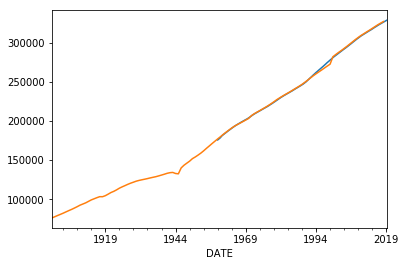

In [641]:
us_pop.set_index('DATE')['POPTHM'].plot()
state_pop.set_index('DATE')['SUM'].plot()

Generate percent population

In [651]:
state_popper = state_pop.drop('SUM',axis=1).copy()

for col in state_popper.columns[1:]:
    state_popper[col] = state_pop[col]/state_pop['SUM']

In [652]:
state_popper = us_pop.merge(state_popper, on='DATE',how='left')

In [668]:
state_popper = state_popper.fillna(method='ffill')
state_popper.tail()

,DATE,POPTHM,AKPOP,ALPOP,ARPOP,AZPOP,CAPOP,COPOP,CTPOP,DCPOP,...,SDPOP,TNPOP,TXPOP,UTPOP,VAPOP,VTPOP,WAPOP,WIPOP,WVPOP,WYPOP
718,2018-11-01,328241.0,0.002254,0.01494,0.009212,0.02192,0.120908,0.017409,0.01092,0.002147,...,0.002697,0.020693,0.087728,0.009662,0.026035,0.001914,0.023033,0.017769,0.00552,0.001766
719,2018-12-01,328393.0,0.002254,0.01494,0.009212,0.02192,0.120908,0.017409,0.01092,0.002147,...,0.002697,0.020693,0.087728,0.009662,0.026035,0.001914,0.023033,0.017769,0.00552,0.001766
720,2019-01-01,328539.0,0.002254,0.01494,0.009212,0.02192,0.120908,0.017409,0.01092,0.002147,...,0.002697,0.020693,0.087728,0.009662,0.026035,0.001914,0.023033,0.017769,0.00552,0.001766
721,2019-02-01,328677.0,0.002254,0.01494,0.009212,0.02192,0.120908,0.017409,0.01092,0.002147,...,0.002697,0.020693,0.087728,0.009662,0.026035,0.001914,0.023033,0.017769,0.00552,0.001766
722,2019-03-01,328817.0,0.002254,0.01494,0.009212,0.02192,0.120908,0.017409,0.01092,0.002147,...,0.002697,0.020693,0.087728,0.009662,0.026035,0.001914,0.023033,0.017769,0.00552,0.001766


In [675]:
state_popmonth = state_popper.copy()
for col in state_popper.columns[2:]:
    state_popmonth[col] = (state_popper[col]*state_popper['POPTHM']).round(3)

state_popmonth.drop('POPTHM', axis=1,inplace=True)
state_popmonth.columns = state_popmonth.columns.str.replace('POP','')


In [676]:
state_popmonth.tail()

,DATE,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
718,2018-11-01,739.858,4903.910,3023.715,7195.179,39686.847,5714.253,3584.388,704.760,970.345,...,885.130,6792.225,28796.027,3171.478,8545.635,628.354,7560.318,5832.645,1811.758,579.633
719,2018-12-01,740.200,4906.181,3025.115,7198.511,39705.225,5716.900,3586.048,705.086,970.794,...,885.540,6795.370,28809.362,3172.946,8549.592,628.645,7563.819,5835.346,1812.597,579.901
720,2019-01-01,740.530,4908.362,3026.460,7201.711,39722.878,5719.441,3587.642,705.400,971.226,...,885.934,6798.392,28822.170,3174.357,8553.393,628.925,7567.182,5837.940,1813.402,580.159
721,2019-02-01,740.841,4910.424,3027.731,7204.736,39739.563,5721.844,3589.149,705.696,971.634,...,886.306,6801.247,28834.277,3175.690,8556.986,629.189,7570.361,5840.392,1814.164,580.403
722,2019-03-01,741.156,4912.515,3029.021,7207.805,39756.490,5724.281,3590.678,705.997,972.047,...,886.683,6804.144,28846.559,3177.043,8560.631,629.457,7573.585,5842.880,1814.937,580.650


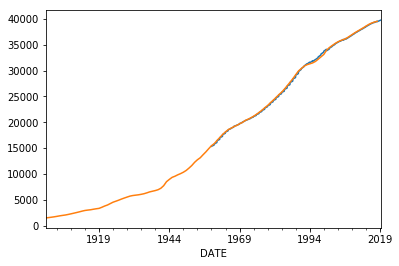

In [679]:
# check if procedure was correct 
state_popmonth.set_index('DATE')['CA'].plot()
state_pop.set_index('DATE')['CAPOP'].plot()

In [685]:
# reformat data 
state_pivot = pd.melt(state_popmonth,id_vars=['DATE'],var_name='State', value_name='Pop')
state_pivot['Year'] = state_pivot['DATE'].dt.year
state_pivot['Month'] = state_pivot['DATE'].dt.month
state_pivot.sort_values(['Year','Month','State'],inplace=True)

In [686]:
state_pivot.head()

,DATE,State,Pop,Year,Month
0,1959-01-01,AK,222.333,1959,1
723,1959-01-01,AL,3180.160,1959,1
1446,1959-01-01,AR,1742.934,1959,1
2169,1959-01-01,AZ,1251.617,1959,1
2892,1959-01-01,CA,15351.916,1959,1


In [687]:
state_pivot.drop('DATE',axis=1).to_csv('E:/Users/Fern/energy_data/clean/state_pop.csv',index=False)

In [2]:
state_pop = pd.read_csv('E:/Users/Fern/energy_data/clean/state_pop.csv')

In [3]:
state_pop.head()

,State,Pop,Year,Month
0,AK,222.333,1959,1
1,AL,3180.160,1959,1
2,AR,1742.934,1959,1
3,AZ,1251.617,1959,1
4,CA,15351.916,1959,1


Remove data before 1989

In [5]:
state_pop = state_pop[state_pop['Year']>=1989]
state_pop.to_csv('E:/Users/Fern/energy_data/clean/state_pop.csv',index=False)

# Heating and Cooling days by State<a id='heatcool'></a>   

Monthly data from ftp://ftp.ncdc.noaa.gov/pub/data/cirs/climdiv/

Details about the data:

- Monthly maximum, minimum and average temperature (deg. F. to 10ths, 
national temperature to 100ths), precipitation (inches to 100ths), 
Standardized Precipitation Index (SPI), and Palmer Drought Indices (PDSI, 
PHDI, PMDI, and ZNDX). Most importanting: heating and cooling degree days, which are number of days with temperature higher or below certain degree and thus heating or air conditioning are required. 

The first three letters are STATE CODE, which stored in state_code.csv:
4 is division number (0 means average over regions)
The 5-6 codes are data type code
7 - 10 are years 

each columns are monthly data starting in Jan 

For example:
001 0 26 1895 mean region 001, cooling degree days in 1895 


In [111]:
# load code maps 
data_code = pd.read_csv(mfolder+'state_temp/data_code.csv',header=None,index_col=0).to_dict()[1]
# load code maps 
state_code = pd.read_csv(mfolder+'state_temp/state_code.csv',header=None,index_col=0,sep='\t').to_dict()[1]

In [816]:
state_code[8]

'Florida'

In [112]:
#load data files
t_files = glob(mfolder+'state_temp/clim*')[:2]
t_files 

['E:/Users/Fern/energy_data/state_temp\\climdiv-cddcst-v1.0.0-20190408',
 'E:/Users/Fern/energy_data/state_temp\\climdiv-hddcst-v1.0.0-20190408']

In [113]:
def clean_clim(file):
    ''' input filename, load the data, replace missing data, extract year
    look up the state code, data code  
    ''' 
    # load data file, remove left white space and split by white space into columns
    df = pd.read_csv(file,header=None).iloc[:,0].str.lstrip().str.split(expand=True)
    #clean up -9999., which mean null 
    df = df.replace('-9999.',np.nan)
    # extract state code 
    df['State_code'] = df.iloc[:,0].str[:3].astype(int)
    # extract data code 
    df['Data_code'] = df.iloc[:,0].str[4:6].astype(int)
    # extract year 
    df['Year'] = df.iloc[:,0].str[6:].astype(int)
    # drop State_code higher than 50 to keep only state data
    df = df[df['State_code'] <=50]
    
    #look up state code
    df['State'] = [state_code[int(code)] for code in df['State_code'].values]
    df['State'] = [us_state_abbrev[name] for name in df['State'].values]
    #look up data code
    df['data'] = [data_code[int(code)] for code in df['Data_code'].values ]
    
    return df

In [114]:
def add_dc(df):
    # add dc data using Maryland's data 
    temp = df[df['State'] =='MD'].copy()
    temp['State'] = 'DC'
    df = pd.concat([df,temp])
    return df

In [115]:
colddays = clean_clim(t_files[0])
# no data from alaska 
colddays = colddays[colddays['State']!='AK']
# add dc data
colddays = add_dc(colddays)

In [116]:
#drop old columns
colddays = colddays.drop([0,'State_code','Data_code'],axis=1)

In [117]:
# reshape df
colddays_melt = colddays.melt(id_vars=['Year','State','data'],var_name='Month',value_name='Cooling_deg_days')
colddays_melt = colddays_melt.drop('data',axis=1)
colddays_melt = colddays_melt.dropna()
colddays_melt['Cooling_deg_days'] = colddays_melt['Cooling_deg_days'].str.replace('.','').astype(int)

In [119]:
colddays_melt.tail()

,Year,State,Month,Cooling_deg_days
73494,2014,DC,12,0
73495,2015,DC,12,7
73496,2016,DC,12,0
73497,2017,DC,12,0
73498,2018,DC,12,0


In [122]:
colddays_melt.max()

Year                2019
State                 WY
Month                 12
Cooling_deg_days     761
dtype: object

Hot day data

In [971]:
hotdays = clean_clim(t_files[1])
# no data from alaska 
hotdays = hotdays[hotdays['State']!='AK']
# add dc data
hotdays = add_dc(hotdays)
#drop old columns
hotdays = hotdays.drop([0,'State_code','Data_code'],axis=1)
# reshape df
hotdays_melt = hotdays.melt(id_vars=['Year','State','data'],var_name='Month',value_name='Heating_deg_days')
hotdays_melt = hotdays_melt.drop('data',axis=1)
hotdays_melt = hotdays_melt.dropna()
hotdays_melt['Heating_deg_days'] = hotdays_melt['Heating_deg_days'].str.replace('.','').astype(int)

In [972]:
hotdays_melt.head()

,Year,State,Month,Heating_deg_days
0,1895,AL,1,716
1,1896,AL,1,692
2,1897,AL,1,751
3,1898,AL,1,544
4,1899,AL,1,689


In [974]:
cold_hot_days = hotdays_melt.merge(colddays_melt,on=['Year','State','Month'])
cold_hot_days.head()

,Year,State,Month,Heating_deg_days,Cooling_deg_days
0,1895,AL,1,716,5
1,1896,AL,1,692,4
2,1897,AL,1,751,4
3,1898,AL,1,544,19
4,1899,AL,1,689,5


In [975]:
cold_hot_days.to_csv(cleanfolder+'cold_hot_days.csv',index=False) 

In [9]:
cold_hot_days = pd.read_csv(cleanfolder+'cold_hot_days.csv')
# drop data before 1989 
cold_hot_days[cold_hot_days['Year']>=1989].to_csv(cleanfolder+'cold_hot_days.csv',index=False) 

# Unemployment by State<a id='ur'></a> 

St. Louis Frederal provides a monthly unempolyment by state. After downloading the data for each state using the API, the data are reformated.

In [724]:
urfiles = glob('E:/Users\Fern/energy_data/umemployment/*.csv')
ex = pd.read_csv(urfiles[0])

In [725]:
ex.head()

,DATE,AKUR
0,1976-01-01,7.1
1,1976-02-01,7.1
2,1976-03-01,7.0
3,1976-04-01,7.0
4,1976-05-01,7.0


In [726]:
def proc_ur(df):
    '''Take in the raw_unemployment data 
    extrac year, month and state output df with year, month, State ID and unemployment data'''
    
    state_id = df.columns[1][:2]
    df.columns = ['DATE','UR']
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['Year'] = df['DATE'].dt.year
    df['Month'] = df['DATE'].dt.month
    df['State'] = state_id
    
    return df.drop('DATE',axis=1)

In [729]:
urall = pd.DataFrame()
for file in urfiles:
    state_ur = proc_ur(pd.read_csv(file))
    urall = pd.concat([urall,state_ur])

urall = urall.sort_values(['Year','Month','State'])

In [731]:
urall.tail()

,UR,Year,Month,State
518,2.3,2019,3,VT
518,4.6,2019,3,WA
518,2.9,2019,3,WI
518,5.1,2019,3,WV
518,3.7,2019,3,WY


In [732]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'

In [733]:
urall.to_csv(cleanfolder+'unemploy.csv',index=False)

In [10]:
urall = pd.read_csv(cleanfolder+'unemploy.csv')
urall[urall['Year']>=1989].to_csv(cleanfolder+'unemploy.csv',index=False)

# Personal Income by State<a id='income'></a> 

St. Louis Frederal provides a quarterly total personal income by state example, https://fred.stlouisfed.org/series/ALOTOT. The income is project by forward fill to obtain a monthly data.


In [741]:
income_files = glob(mfolder+'personal_income/*.csv')
inc = pd.read_csv(income_files[0])

In [738]:
inc.head()

,DATE,AKOTOT
0,1950-01-01,343.4
1,1950-04-01,373.8
2,1950-07-01,408.5
3,1950-10-01,439.8
4,1951-01-01,470.5


In [749]:
def proc_in(df):
    '''Take in the raw_income data 
    extrac year, month and state output df with year, month, State ID and income data'''
    
    state_id = df.columns[1][:2]
    df.columns = ['DATE','Income']
    # change date column to datetime data 
    df['DATE'] = pd.to_datetime(df['DATE'])
    # set as index
    df = df.set_index('DATE')    
    #resample to get montly data
    df = df['Income'].resample('1M').bfill()
    #reset index 
    df = df.reset_index()
    # extract year and month 
    df['Year'] = df['DATE'].dt.year
    df['Month'] = df['DATE'].dt.month
    df['State'] = state_id
    
    return df.drop('DATE',axis=1)

In [750]:
inall = pd.DataFrame()
for file in income_files:
    state_in = proc_in(pd.read_csv(file))
    inall = pd.concat([inall,state_in])

inall = inall.sort_values(['Year','Month','State'])
inall.head()

,Income,Year,Month,State
0,2595.6,1948,1,AL
0,1645.4,1948,1,AR
0,919.4,1948,1,AZ
0,18093.5,1948,1,CA
0,1861.0,1948,1,CO


In [752]:
inall.to_csv(cleanfolder+'totalincome.csv',index=False)

In [11]:
inall = pd.read_csv(cleanfolder+'totalincome.csv')
inall[inall['Year']>=1989].to_csv(cleanfolder+'totalincome.csv',index=False)

#  Consumer Price Index US<a id='cpi'></a> 

St. Louis Frederal summarizes a monthly consumer price index excluding food and electricity in https://fred.stlouisfed.org/series/CPILFENS. The same numer is used for all states. 


In [754]:
cpi = pd.read_csv(mfolder+'consumer-price_index_CPILFENS.csv')
cpi.head()

,DATE,CPILFENS
0,1957-01-01,28.5
1,1957-02-01,28.5
2,1957-03-01,28.7
3,1957-04-01,28.8
4,1957-05-01,28.8


In [755]:
cpi.columns = ['DATE','CPI']
cpi['DATE'] = pd.to_datetime(cpi['DATE'])
cpi['Year'] = cpi['DATE'].dt.year
cpi['Month'] = cpi['DATE'].dt.month


In [756]:
cpi.drop('DATE',axis=1).to_csv(cleanfolder+'consumer_price_idx.csv',index=False)

# GDP per state (GSP)<a id='gsp'></a> 

There are annual GSP by state from https://apps.bea.gov/regional/downloadzip.cfm, and quarterly GSP by state from https://fred.stlouisfed.org. The data are put together and forward fill to obtain a monthly data.

In [4]:
bea_files = glob(mfolder+'GDP_BEA/*.csv')
gsp1 = pd.read_csv(bea_files[0])
gsp1 = gsp1[gsp1['CODE']==1]
gsp1.head(2)

,ID,COMPONENT,FIPS,REGION,CODE,INDUSTRY,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,200,Gross Domestic Product by State (millions of c...,1.0,Alabama,1.0,All industry total,101808,106459,112041,116014,120112,125138,130835,142086,151096,159263,166217,171748,169856
81,200,Gross Domestic Product by State (millions of c...,2.0,Alaska,1.0,All industry total,25171,23312,23866,25913,27747,28887,30905,34408,37824,41820,44288,48551,45709


In [5]:
gsp2 = pd.read_csv(bea_files[1])
gsp2.columns = gsp2.columns.str.strip()
gsp2 =  gsp2[gsp2['CODE']==0]

# gsp2 columns has extra space, need to remove it before
for col in gsp2.columns:
    if gsp2[col].dtype=='O':
        gsp2[col]=gsp2[col].str.strip()

gsp2.head(2)

,ID,COMPONENT,FIPS,REGION,CODE,INDUSTRY,1977,1978,1979,1980,...,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997
0,200,Gross State Product (millions of current dollars),1.0,Alabama,0.0,Total Gross State Product,26546,30377,33535,36006,...,65435,67875,71085,75293,80450,83453,88581,94021,97941,102533
78,200,Gross State Product (millions of current dollars),2.0,Alaska,0.0,Total Gross State Product,7492,9088,10863,15138,...,21307,23357,24987,22164,22591,22965,23110,24805,26083,26884


In [6]:
def proc_gsp(gsp):
    
    gsp = gsp[gsp['REGION'].isin([*us_state_abbrev])].copy()
    gsp['State'] = [us_state_abbrev[code] for code in gsp['REGION'] ]
    gsp = gsp.drop(['ID', 'COMPONENT', 'FIPS', 'CODE','INDUSTRY','REGION'],axis=1)
    
    return gsp    

In [7]:
gsp1 = proc_gsp(gsp1).sort_values('State').set_index('State')
gsp2 = proc_gsp(gsp2).sort_values('State').set_index('State')

In [11]:
gsp_bea = gsp1.merge(gsp2.drop('1997',axis=1),left_index=True, right_index=True,how='outer').reset_index()

In [12]:
gsp_bea.head()

,State,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996
0,AK,25171,23312,23866,25913,27747,28887,30905,34408,37824,...,22258,21307,23357,24987,22164,22591,22965,23110,24805,26083
1,AL,101808,106459,112041,116014,120112,125138,130835,142086,151096,...,60586,65435,67875,71085,75293,80450,83453,88581,94021,97941
2,AR,59837,61765,66091,68146,70925,73953,77767,83551,88227,...,32190,34508,36647,38109,40950,44312,46599,50179,53303,56455
3,AZ,128099,139289,151188,161901,170174,177106,189139,201287,222968,...,59171,63639,66390,69322,72263,79695,85157,95292,104036,113138
4,CA,1.03785e+006,1.1128e+006,1.21022e+006,1.31734e+006,1.33805e+006,1.38575e+006,1.4603e+006,1.5712e+006,1.69199e+006,...,620177,678774,734406,788322,801193,819389,833656,862481,908963,958476


In [14]:
gsp_bea['State'].unique().shape

(51,)

In [15]:
gsp_bea_all = gsp_bea.melt(id_vars=['State'],var_name='Year', value_name='GSP').sort_values(['Year','State'])

In [16]:
gsp_bea_all['Year'].unique()

array(['1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'], dtype=object)

In [17]:
gsp_bea_all['Year'] = gsp_bea_all['Year'].astype(int)
# keep only 1989 to 2004 
gsp_bea_all = gsp_bea_all[gsp_bea_all['Year']<=2004]
gsp_bea_all = gsp_bea_all[gsp_bea_all['Year']>=1989]

In [18]:
gsp_bea_all['Year'] = pd.to_datetime(gsp_bea_all['Year'],format='%Y')

In [19]:
gsp_bea_all.columns = ['State','DATE','GSP'] 

GSP from St.Louis Fed 

In [20]:
#quarter files from 2005 to 2018
gspq_fed_files = glob(mfolder+'GDP_stlouisfed/*NQGSP.csv')

In [21]:
def proc_gsp(file):
    df = pd.read_csv(file)
    df.columns = ['DATE', df.columns[1][:2]]
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.melt(id_vars=['DATE'],var_name='State', value_name='GSP').sort_values(['DATE','State'])
    return df

In [22]:
gsp_all = pd.DataFrame()
for file in gspq_fed_files:
    gsp_all = pd.concat([gsp_all,proc_gsp(file)])
    

In [23]:
gsp = pd.concat([gsp_bea_all, gsp_all],sort=True)

In [24]:
gsp.head()

,DATE,GSP,State
1275,1989-01-01,23357,AK
1276,1989-01-01,67875,AL
1277,1989-01-01,36647,AR
1278,1989-01-01,66390,AZ
1279,1989-01-01,734406,CA


In [25]:
gsp.tail()

,DATE,GSP,State
50,2017-07-01,37978.9,WY
51,2017-10-01,39110.8,WY
52,2018-01-01,39503.1,WY
53,2018-04-01,40384.2,WY
54,2018-07-01,40994.6,WY


In [26]:
def resample_bystate(state):
    temp = gsp[gsp['State']==state]
    row =  pd.DataFrame.from_dict({'DATE':['2018-12-01'],
                                   'GSP':[temp.iloc[-1,1]],
                                   'State':[state]})
    row['DATE'] = pd.to_datetime(row['DATE'])
    temp = pd.concat([temp,row]).set_index('DATE')
    temp = temp.resample('1M').ffill()
    temp.head()
    
    return temp  

In [27]:
gsp_resam = pd.DataFrame()
for state in gsp['State'].unique():
    gsp_resam = pd.concat([gsp_resam,resample_bystate(state)])

In [28]:
gsp_resam = gsp_resam.reset_index()
gsp_resam['Year']=gsp_resam['DATE'].dt.year
gsp_resam['Month']=gsp_resam['DATE'].dt.month
gsp_resam.head()

,DATE,GSP,State,Year,Month
0,1989-01-31,23357,AK,1989,1
1,1989-02-28,23357,AK,1989,2
2,1989-03-31,23357,AK,1989,3
3,1989-04-30,23357,AK,1989,4
4,1989-05-31,23357,AK,1989,5


In [32]:
gsp_resam[(gsp_resam['State']=='DC')&(gsp_resam['Year']== 1997)]

,DATE,GSP,State,Year,Month
2616,1997-01-31,50259,DC,1997,1
2617,1997-02-28,50259,DC,1997,2
2618,1997-03-31,50259,DC,1997,3
2619,1997-04-30,50259,DC,1997,4
2620,1997-05-31,50259,DC,1997,5
2621,1997-06-30,50259,DC,1997,6
2622,1997-07-31,50259,DC,1997,7
2623,1997-08-31,50259,DC,1997,8
2624,1997-09-30,50259,DC,1997,9
2625,1997-10-31,50259,DC,1997,10


In [33]:
gsp_resam.drop(['DATE'],axis=1).to_csv(cleanfolder+'gsp_all.csv',index=False)

# Short Term Energy Outlook<a id='steo'></a> 

Our prediction is going to be benchmark against the short term energy outlook (STEO) from eia website. It is a monthly electricity consumption by regions (not by state) for each sector.The data start on Jan 2015 and end on Dec 2020. The unit of each column is billion kilowatthours  per day; therefore has to convert per day consumption to total monthly consumption.

**Note: the unit billion kilowatthours should be be million kilowatt hours. The total monthly consumption for the US is around 300,000 million kWh which is about 10,000 kWh per day. If the unit in the STEO is really billion kWh, then the projection is off by 1000 times. I am going to assume that the unit is million kWh**

In [8]:
steo = pd.read_csv(mfolder+'energy_outlook/STEO_Regional_Electricity_Retail_Sales.csv',skiprows=4,sep='\t')
steo.head()

,remove,Unnamed: 1,map,linechart,units,source key,Jan 2015,Feb 2015,Mar 2015,Apr 2015,...,Mar 2020,Apr 2020,May 2020,Jun 2020,Jul 2020,Aug 2020,Sep 2020,Oct 2020,Nov 2020,Dec 2020
0,New England,Electricity Residential Sales: New England,1.0,1.0,billion kilowatthours per day,EXRCP_NEC,154.0,167.0,139.0,119.0,...,126.0,113.0,100.0,124.0,148.0,142.0,128.0,106.0,118.0,131.0
1,Middle Atlantic,Electricity Residential Sales: Middle Atlantic,1.0,1.0,billion kilowatthours per day,EXRCP_MAC,429.0,451.0,391.0,311.0,...,351.0,300.0,280.0,364.0,449.0,424.0,381.0,304.0,313.0,373.0
2,East North Central,Electricity Residential Sales: East North Central,1.0,1.0,billion kilowatthours per day,EXRCP_ENC,622.0,629.0,517.0,391.0,...,471.0,406.0,399.0,531.0,654.0,591.0,484.0,418.0,458.0,545.0
3,West North Central,Electricity Residential Sales: West North Central,1.0,1.0,billion kilowatthours per day,EXRCP_WNC,354.0,348.0,279.0,213.0,...,273.0,231.0,216.0,291.0,346.0,337.0,269.0,226.0,254.0,324.0
4,South Atlantic,Electricity Residential Sales: South Atlantic,1.0,1.0,billion kilowatthours per day,EXRCP_SAC,1125.0,1160.0,974.0,758.0,...,884.0,763.0,812.0,1086.0,1246.0,1211.0,1024.0,870.0,850.0,997.0


In [9]:
steo['Sector'] = steo[steo.columns[1]].str.split(' ',expand=True)[1]
steo = steo.drop(steo.columns[1:6],axis=1)

In [10]:
steo = steo.melt(id_vars=['remove','Sector'],var_name='Year-Month', value_name='Sale')
steo.columns =['Regions','Sector','Year-Month','Sale']
steo.head()

,Regions,Sector,Year-Month,Sale
0,New England,Residential,Jan 2015,154.0
1,Middle Atlantic,Residential,Jan 2015,429.0
2,East North Central,Residential,Jan 2015,622.0
3,West North Central,Residential,Jan 2015,354.0
4,South Atlantic,Residential,Jan 2015,1125.0


In [20]:
steo_pivot = steo.pivot_table(index=['Regions','Year-Month'], columns='Sector').reset_index().copy()

In [21]:
steo_pivot.head()

Regions Year-Month       Sale                             
Sector                               Commercial Industrial Residential Total
0       Alaska and Hawaii   Apr 2015       16.0       14.0        12.0  42.0
1       Alaska and Hawaii   Apr 2016       16.0       14.0        12.0  41.0
2       Alaska and Hawaii   Apr 2017       16.0       14.0        12.0  42.0
3       Alaska and Hawaii   Apr 2018       16.0       13.0        13.0  41.0
4       Alaska and Hawaii   Apr 2019       16.0       13.0        12.0  41.0

In [22]:
steo_pivot.columns = ['Regions','Year-Month','STEO_Sale_COM','STEO_Sale_IND','STEO_Sale_RES','STEO_Sale_All']

In [23]:
# check regions consistency
steo_pivot['Regions'].unique()

array(['Alaska and Hawaii', 'East North Central', 'East South Central', 'Middle Atlantic', 'Mountain',
       'New England', 'Pacific contiguous', 'South Atlantic', 'Total', 'West North Central',
       'West South Central'], dtype=object)

Region name are inconsistent. The STEO call 'Alaska and Hawaii', but the other datasets use 'Pacific Noncontiguous'

In [24]:
# Remove the total consumption row  
steo_pivot = steo_pivot[~steo_pivot['Regions'].isin(['Total'])]
steo_pivot['Regions'] = steo_pivot['Regions'].str.replace('Alaska and Hawaii','Pacific Noncontiguous')
steo_pivot['Regions'] = steo_pivot['Regions'].str.replace('Pacific contiguous','Pacific Contiguous')

In [25]:
# create date-time 
steo_pivot['Year-Month'] = pd.to_datetime(steo_pivot['Year-Month'])
steo_pivot['Year'] = steo_pivot['Year-Month'].dt.year
steo_pivot['Month'] = steo_pivot['Year-Month'].dt.month
steo_pivot = steo_pivot.sort_values(['Year','Month','Regions'])

Calculate the total monthly sale 

In [26]:
# generate number of days in that month
steo_pivot['num_days'] =  [pd.Period(month,freq='M').days_in_month for month in steo_pivot['Year-Month'].values]
# convert to total sales 
cols = ['STEO_Sale_COM', 'STEO_Sale_IND', 'STEO_Sale_RES', 'STEO_Sale_All']
for col in cols:
    steo_pivot[col] = steo_pivot[col]*steo_pivot['num_days']

In [27]:
steo_pivot = steo_pivot.drop('num_days',axis=1)

In [28]:
# calculate total sale without other sector
steo_pivot['STEO_Sale_ALL_no_OTH'] = steo_pivot[['STEO_Sale_COM', 'STEO_Sale_IND', 'STEO_Sale_RES']].sum(axis=1)

In [29]:
steo_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 96 to 737
Data columns (total 9 columns):
Regions                 720 non-null object
Year-Month              720 non-null datetime64[ns]
STEO_Sale_COM           720 non-null float64
STEO_Sale_IND           720 non-null float64
STEO_Sale_RES           720 non-null float64
STEO_Sale_All           720 non-null float64
Year                    720 non-null int64
Month                   720 non-null int64
STEO_Sale_ALL_no_OTH    720 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 56.2+ KB


In [30]:
steo_pivot.tail()

,Regions,Year-Month,STEO_Sale_COM,STEO_Sale_IND,STEO_Sale_RES,STEO_Sale_All,Year,Month,STEO_Sale_ALL_no_OTH
449,Pacific Contiguous,2020-12-01,12803.0,6417.0,13268.0,32581.0,2020,12,32488.0
17,Pacific Noncontiguous,2020-12-01,465.0,403.0,403.0,1271.0,2020,12,1271.0
521,South Atlantic,2020-12-01,24552.0,10168.0,30907.0,65720.0,2020,12,65627.0
665,West North Central,2020-12-01,8742.0,7316.0,10044.0,26071.0,2020,12,26102.0
737,West South Central,2020-12-01,15469.0,14601.0,17298.0,47399.0,2020,12,47368.0


In [31]:
steo_pivot.to_csv(cleanfolder+'steo.csv',index=False)

# Regional group <a id='group'></a> 

EIA group the states into sub regions. This group is handy and could be used as a feature. We need a data that map if a state belong to which group  

In [32]:
region = pd.read_csv(mfolder+'energy/Retail_sales_of_electricity.csv',skiprows=4,usecols=[0,2])
region.head()

,description,source key
0,United States : all sectors,ELEC.SALES.US-ALL.M
1,United States : residential,ELEC.SALES.US-RES.M
2,United States : commercial,ELEC.SALES.US-COM.M
3,United States : industrial,ELEC.SALES.US-IND.M
4,United States : transportation,ELEC.SALES.US-TRA.M


In [33]:
# extract region name 
region['Regions'] = region['description'].str.split(':',expand=True)[0]
# strip right white space 
region['Regions'] = region['Regions'].str.rstrip() 
# extract region abbreviation
region['Regions_abb'] = region['source key'].str.split('.',expand=True)[2].str.split('-',expand=True)[0]
# drop US row 
region = region[region['Regions_abb']!='US']
# keep only the Regions and Region_abb columns 
region = region[['Regions','Regions_abb']]

In [34]:
# separate region and State columns out 
region['State'] = [state if len(state)==2 else np.nan for state in region['Regions_abb'] ]

idxs =  region[region['Regions_abb'].str.len()==2].index
region.loc[idxs, 'Regions'] = np.nan

In [35]:
region['Regions'] = region['Regions'].fillna(method='ffill')

In [36]:
region = region.dropna().drop('Regions_abb',axis=1)

In [37]:
region = region.drop_duplicates()

In [38]:
region.to_csv(cleanfolder+'region.csv',index=False)

# State Size <a id='size'></a>

Instead of the population, population density could be an important feature. I use the data from wikipedia. 

In [40]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area#cite_note-2010census-2'
size = pd.read_html(url)[0]
size = size.iloc[:51,[0,6]]
size.columns = ['State','Area']

In [41]:
size.tail()

,State,Area
46,New Jersey,19047
47,Connecticut,12542
48,Delaware,5047
49,Rhode Island,2678
50,District of Columbia,158


In [42]:
size['State'] = size['State'].replace(us_state_abbrev)

In [43]:
size.to_csv(cleanfolder+'size.csv',index=False)

# Combine all data <a id='combine'></a> 

In [44]:
# obtain electricity data sale, numer of customer, price and revenue 
sale = pd.read_csv(cleanfolder+'sale.csv',sep='\t')
num_cus = pd.read_csv(cleanfolder+'customer.csv')
price = pd.read_csv(cleanfolder+'price.csv',sep='\t')
rev = pd.read_csv(cleanfolder+'revenue.csv',sep='\t')

In [45]:
#load number of hot cold day
ch_days = pd.read_csv(cleanfolder+'cold_hot_days.csv')
# load consumer price index (exclude food and energy)
cpi = pd.read_csv(cleanfolder+'consumer_price_idx.csv')
# state population
pop = pd.read_csv(cleanfolder+'state_pop.csv')
# total income by state 
income = pd.read_csv(cleanfolder+'totalincome.csv')
# unemployment by state 
unem = pd.read_csv(cleanfolder+'unemploy.csv')
# GSP
gsp = pd.read_csv(cleanfolder+'gsp_all.csv')
# regional group
region = pd.read_csv(cleanfolder+'region.csv')
# size of each state 
size = pd.read_csv(cleanfolder+'size.csv')

In [46]:
# comebine all data 
combine = sale.merge(price, on=['Year','Month','State'],how='left')
combine = combine.merge(rev, on=['Year','Month','State'],how='left')
combine = combine.merge(num_cus, on=['Year','Month','State'],how='left')
combine = combine.merge(ch_days, on=['Year','Month','State'],how='left')
combine = combine.merge(pop, on = ['Year','Month','State'],how='left')
combine = combine.merge(income, on = ['Year','Month','State'],how='left')
combine = combine.merge(unem, on = ['Year','Month','State'],how='left')
combine = combine.merge(gsp, on = ['Year','Month','State'],how='left')
combine = combine.merge(cpi, on=['Year','Month'],how='left')
combine = combine.merge(region, on=['State'],how='left')
combine = combine.merge(size, on=['State'],how='left')

In [47]:
# create year-month columns
combine['Year-Month'] = combine['Year'].astype(str) + combine['Month'].astype(str)
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'],format='%Y%m')
# population density
combine['Density'] = combine['Pop']/combine['Area']
combine.drop('Area',axis=1,inplace=True)

The machine learning models will work on the data in the residential, commercial and industrial sector. I will need another a total column for all consumption without the 'OTH' columns. 

In [48]:
combine['Sale_ALL_no_OTH'] = combine['Sale_RES'] + combine['Sale_IND'] + combine['Sale_COM'] 

In [49]:
combine.head()

,Year,Month,State,Sale_RES,Sale_COM,Sale_IND,Sale_OTH,Sale_ALL,Price_RES,Price_COM,...,Cooling_deg_days,Pop,Income,UR,GSP,CPI,Regions,Year-Month,Density,Sale_ALL_no_OTH
0,1990,1,AK,181.75,178.26,41.61,14.82,416.44,9.62,8.87,...,NaN,551.520,12776.9,7.2,24987.0,132.0,Pacific Noncontiguous,1990-01-01,0.000373,401.62
1,1990,1,AL,2070.09,820.42,2099.55,53.95,5044.01,5.96,6.64,...,21.0,4036.801,64029.4,6.7,71085.0,132.0,East South Central,1990-01-01,0.030775,4990.06
2,1990,1,AR,1026.32,474.99,782.49,47.60,2331.40,7.06,6.52,...,5.0,2347.535,34283.2,6.7,38109.0,132.0,West South Central,1990-01-01,0.017419,2283.80
3,1990,1,AZ,1396.50,1081.79,809.80,151.06,3439.15,7.83,7.64,...,0.0,3668.417,63546.7,5.2,69322.0,132.0,Mountain,1990-01-01,0.012469,3288.09
4,1990,1,CA,6168.01,6011.77,4454.66,869.56,17504.01,9.68,8.46,...,0.0,29863.502,640724.9,5.2,788322.0,132.0,Pacific Contiguous,1990-01-01,0.074017,16634.44


In [50]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17850 entries, 0 to 17849
Data columns (total 34 columns):
Year                17850 non-null int64
Month               17850 non-null int64
State               17850 non-null object
Sale_RES            17850 non-null float64
Sale_COM            17850 non-null float64
Sale_IND            17850 non-null float64
Sale_OTH            17850 non-null float64
Sale_ALL            17850 non-null float64
Price_RES           17850 non-null float64
Price_COM           17850 non-null float64
Price_IND           17850 non-null float64
Price_OTH           17850 non-null float64
Price_ALL           17850 non-null float64
Rev_RES             17850 non-null float64
Rev_COM             17850 non-null float64
Rev_IND             17850 non-null float64
Rev_OTH             17850 non-null float64
Rev_ALL             17850 non-null float64
Cus_RES             17850 non-null int64
Cus_COM             17850 non-null int64
Cus_IND             17842 non-null float

In [51]:
combine.to_csv(cleanfolder+'combine.csv',index=False)

# Explore missing data <a id='missing'></a> 

Explore missing data in other states, which is not HI and AK. 

In [32]:
combine = pd.read_csv(cleanfolder+'combine.csv')
# find all the null values 
missing = combine[combine.isnull().any(axis=1)]

In [33]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 34 columns):
Year                17850 non-null int64
Month               17850 non-null int64
State               17850 non-null object
Sale_RES            17850 non-null float64
Sale_COM            17850 non-null float64
Sale_IND            17850 non-null float64
Sale_OTH            17850 non-null float64
Sale_ALL            17850 non-null float64
Price_RES           17850 non-null float64
Price_COM           17850 non-null float64
Price_IND           17850 non-null float64
Price_OTH           17850 non-null float64
Price_ALL           17850 non-null float64
Rev_RES             17850 non-null float64
Rev_COM             17850 non-null float64
Rev_IND             17850 non-null float64
Rev_OTH             17850 non-null float64
Rev_ALL             17850 non-null float64
Cus_RES             17850 non-null int64
Cus_COM             17850 non-null int64
Cus_IND             17842 non-null float

In [132]:
missing.head()

,Year,Month,State,Sale_RES,Sale_COM,Sale_IND,Sale_OTH,Sale_ALL,Price_RES,Price_COM,...,Cooling_deg_days,Pop,Income,UR,GSP,CPI,Regions,Year-Month,Sale_ALL_no_OTH,Density
0,1990,1,AK,181.75,178.26,41.61,14.82,416.44,9.62,8.87,...,NaN,551.520,12776.9,7.2,24987.0,132.0,Pacific Noncontiguous,1990-01-01,401.62,0.000373
7,1990,1,DC,168.77,447.25,237.96,29.48,883.46,5.62,5.26,...,0.0,602.068,15743.5,5.3,NaN,132.0,South Atlantic,1990-01-01,853.98,3.810557
11,1990,1,HI,206.58,168.39,290.73,4.82,670.52,9.52,9.60,...,NaN,1109.485,24725.6,2.7,31898.0,132.0,Pacific Noncontiguous,1990-01-01,665.70,0.066696
51,1990,2,AK,177.50,174.40,39.44,17.18,408.52,9.47,8.80,...,NaN,551.913,12776.9,7.2,24987.0,132.8,Pacific Noncontiguous,1990-02-01,391.34,0.000373
58,1990,2,DC,120.48,399.53,224.48,25.78,770.27,5.58,5.43,...,0.0,602.496,15743.5,5.5,NaN,132.8,South Atlantic,1990-02-01,744.49,3.813266


In [133]:
missing = missing[~missing['State'].isin(['AK','HI'])]

In [134]:
missing.head().T

,7,58,109,160,211
Year,1990,1990,1990,1990,1990
Month,1,2,3,4,5
State,DC,DC,DC,DC,DC
Sale_RES,168.77,120.48,120.96,105.25,92.46
Sale_COM,447.25,399.53,396.2,366.3,381.85
Sale_IND,237.96,224.48,227.04,217.14,237.69
Sale_OTH,29.48,25.78,25.38,25.5,24.58
Sale_ALL,883.46,770.27,769.58,714.19,736.58
Price_RES,5.62,5.58,5.34,5.29,5.26
Price_COM,5.26,5.43,5.36,5.45,5.47


In [135]:
missing.tail().T

,17845,17846,17847,17848,17849
Year,2019,2019,2019,2019,2019
Month,2,2,2,2,2
State,VT,WA,WI,WV,WY
Sale_RES,196,3899,1946,1097,285
Sale_COM,157,2493,1848,573,301
Sale_IND,103,1837,1831,1104,826
Sale_OTH,0,5,0,0,0
Sale_ALL,457,8234,5625,2774,1411
Price_RES,16.67,9.4,14.15,9.98,10.61
Price_COM,16.07,8.69,10.95,9.36,9.53


 - missing data for coolig and heating days for AK
 - missing early 1990 GSP data for DC 
 - Missing income and GSP data from October 2018 to 2019